In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from get_votes import votes

In [2]:
with open("res.pkl", "rb") as f:
    res = pickle.load(f)

In [3]:
def parse_metadata(names):
    pref, _ = names.split(".")
    artist, version, orig, presence = pref.split("-")
    return orig, [int(x) for x in presence]

imgs = np.stack([x["features"] for x in res])
metadata = [parse_metadata(x["img"]) for x in res]
filename_mappings = { x["img"][:-4]: i for i, x in enumerate(res) }

In [4]:
NUM_SKETCHES = len(imgs)
NUM_SKETCHES

336

In [5]:
face_feature_matrix = np.stack([bits for _, bits in metadata])

# Part 1: Vote analysis

In [6]:
# Augment dataset with helper features
chosen_index = pd.Series([filename_mappings[v[:-4]] for v in votes["chosen_image_filename"]])
votes["chosen_index"] = chosen_index
other_index = pd.Series([filename_mappings[v[:-4]] for v in votes["other_image_filename"]])
votes["other_index"] = other_index
true_image = pd.Series([metadata[idx][0] for idx in chosen_index])
true_other_image = pd.Series([metadata[idx][0] for idx in other_index])
votes["true_image"] = true_image
assert (true_other_image == true_image).all()

In [7]:
votes

,username,chosen_image_filename,timestamp,other_image_filename,chosen_index,other_index,true_image
0,4321,D4-1-106-111110.png,2023-02-22 10:50:18.702394,D3-3-106-111110.png,325,86,106
1,4321,D4-2-1501-110111.png,2023-02-22 10:50:18.702394,D3-3-1501-111100.png,205,0,1501
2,4321,D2-2-883-010111.png,2023-02-22 10:50:18.702394,D2-1-883-010110.png,4,209,883
3,4321,D4-2-100-011101.png,2023-02-22 10:50:18.702394,D2-3-100-110111.png,159,265,100
4,4321,D4-3-1527-111101.png,2023-02-22 10:50:18.702394,D1-2-1527-101011.png,291,186,1527
...,...,...,...,...,...,...,...
10997,39084512,D4-3-270-110111.png,2023-03-06 20:23:40.897905,D4-1-270-101011.png,96,143,270
10998,39084512,D1-2-883-010111.png,2023-03-06 20:23:40.897905,D4-1-883-111010.png,78,335,883
10999,39084512,D2-2-1344-100111.png,2023-03-06 20:23:40.897905,D2-3-1344-101011.png,23,177,1344
11000,39084512,D2-2-1501-010111.png,2023-03-06 20:23:40.897905,D2-3-1501-001111.png,260,201,1501


In [31]:
votes.groupby(["chosen_image_filename"]).apply(len)

chosen_image_filename
D1-1-100-111110.png     33
D1-1-100-111111.png     47
D1-1-1041-101111.png    51
D1-1-1041-111111.png    50
D1-1-106-101111.png     13
                        ..
D4-3-270-110111.png     25
D4-3-354-001101.png      9
D4-3-354-101101.png     16
D4-3-883-011000.png     13
D4-3-883-011100.png     24
Length: 334, dtype: int64

In [8]:
votes.groupby("username").apply(len)

username
01185513    351
18411688    457
18608140    480
18633534    454
19352589    806
27927048    991
28038265    737
29445918    632
31138293    456
33064162    990
34230999    453
38249914    839
38925025     60
38957409     30
39071869     90
39084512     60
4321         30
48297413    982
48426757    572
48600911    960
57155238    572
dtype: int64

In [9]:
len(votes["other_image_filename"].unique())

335

(array([ 4., 15., 13., 17., 14., 17.,  9., 19., 28., 26., 26., 21., 22.,
        25., 21., 20., 16., 11., 11.,  1.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

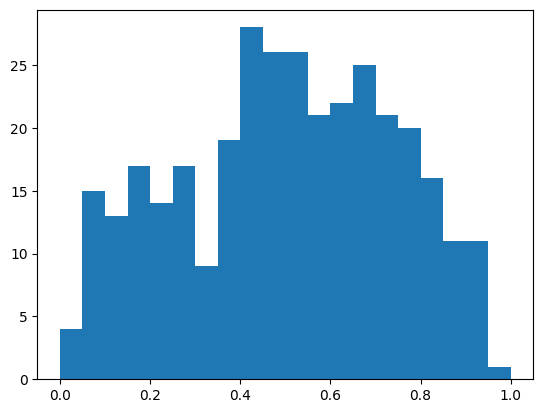

In [10]:
def calc_average_votes(f, a):
    if f + a == 0:
        return np.nan
    return f/(f+a)

votes_for = votes.groupby("chosen_index").apply(len)
votes_against = votes.groupby("other_index").apply(len)

vote_merged = np.array([(votes_for.get(x, default=0), votes_against.get(x, default=0)) for x in range(NUM_SKETCHES)])
vote_prop = np.array([calc_average_votes(f, a) for f, a in vote_merged])
plt.hist(vote_prop, bins=20)

In [11]:
[res[i]["img"] for i in np.argsort(vote_prop)[:10]]

['D2-1-883-010010.png',
 'D4-2-1527-101110.png',
 'D2-1-106-001010.png',
 'D4-3-1204-010000.png',
 'D4-1-883-111110.png',
 'D4-2-1195-011100.png',
 'D3-1-1195-111101.png',
 'D4-1-883-111010.png',
 'D4-3-1344-111000.png',
 'D2-1-1955-110100.png']

# Experiment 1: Predict P(Si beats random image in dataset)

In [39]:
W_train, W_test, X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(face_feature_matrix, imgs, vote_prop)

In [40]:
def sigmoid(x):
    return 1/(np.exp(-x) + 1)

def inv_sigmoid(x):
    x = np.clip(x, 0.001, 0.999)
    return -np.log(1/x - 1)

# SKLearn has no Logistic regression regressor, so we have to improvise their linear regression by transforming data under sigmoid
lr2 = Ridge()
lr2.fit(X_train, inv_sigmoid(y_train))

Ridge()

Text(0, 0.5, 'Actual')

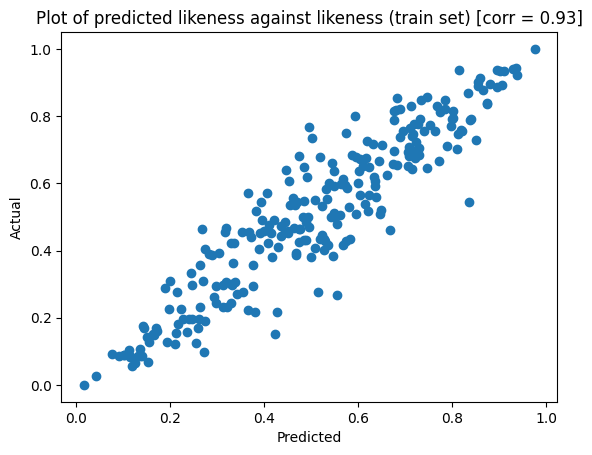

In [44]:
vals = sigmoid(lr2.predict(X_train))
accuracies = y_train

fig, ax = plt.subplots()

ax.set_title(f"Plot of predicted likeness against likeness (train set) [corr = {np.corrcoef(vals, accuracies)[0,1]:.2f}]")
ax.scatter(vals, accuracies)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

Text(0, 0.5, 'Actual')

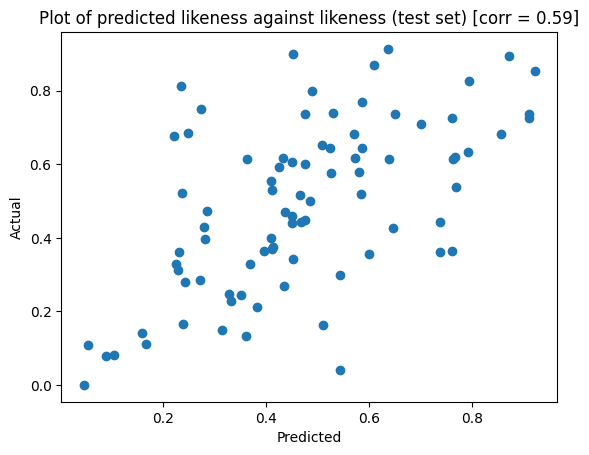

In [45]:
vals = sigmoid(lr2.predict(X_test))
accuracies = y_test

fig, ax = plt.subplots()

ax.set_title(f"Plot of predicted likeness against likeness (test set) [corr = {np.corrcoef(vals, accuracies)[0,1]:.2f}]")
ax.scatter(vals, accuracies)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

In [46]:
mae = np.abs(vals - accuracies).mean()
mse = ((vals - accuracies) ** 2).mean()
bce = - (accuracies * np.log(vals) + (1 - accuracies) * np.log(1 - vals)).mean()
print(f"Mean Absolute Error = {mae}")
print(f"Mean Square Error = {mse}")
print(f"Root Mean Square Error = {np.sqrt(mse)}")
print(f"Binary Cross Entropy = {bce}")

Mean Absolute Error = 0.15008127896250553
Mean Square Error = 0.0399937557917346
Root Mean Square Error = 0.19998438887006806
Binary Cross Entropy = 0.6695385610071174


## K-fold cross-validation

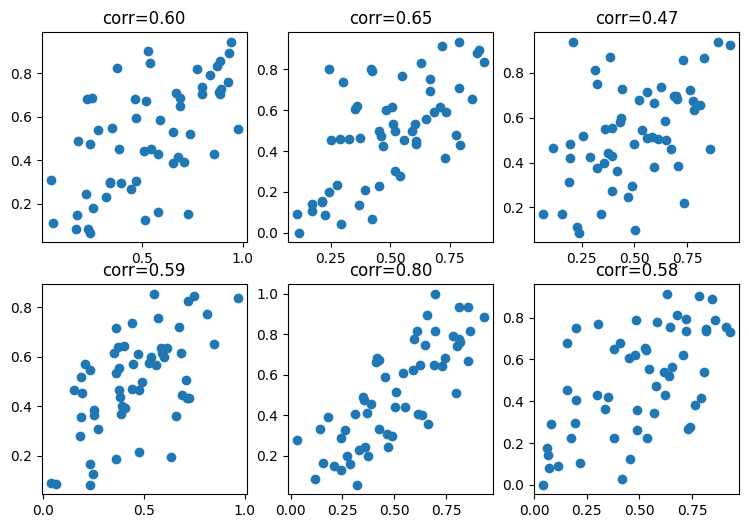

In [47]:
K = 6
cols = 3

rows = (K + 2) // 3
fig, ax = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

cv = sklearn.model_selection.KFold(n_splits=K)
for i, (train, test) in enumerate(cv.split(imgs)):
    _x_train, _x_test, _y_train, _y_test = imgs[train], imgs[test], vote_prop[train], vote_prop[test]
    lr2 = Ridge()
    lr2.fit(_x_train, inv_sigmoid(_y_train))
    
    _y_pred = sigmoid(lr2.predict(_x_test))
    
    ax[i // cols, i % cols].set_title(f"corr={np.corrcoef(_y_pred, _y_test)[0,1]:.2f}")
    ax[i // cols, i % cols].scatter(_y_pred, _y_test)

# Experiment 2: Calculate feature importances

In [48]:
#def sigmoid(x):
#    return 1/(np.exp(-x) + 1)

#def inv_sigmoid(x):
#    x = np.clip(x, 0.001, 0.999)
#    return -np.log(1/x - 1)

# SKLearn has no Logistic regression regressor, so we have to improvise their linear regression by transforming data under sigmoid
lr3 = Ridge(fit_intercept=False)
lr3.fit(W_train, (y_train))

Ridge(fit_intercept=False)

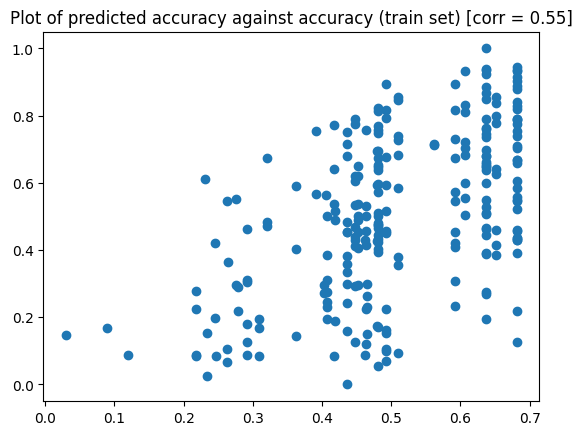

In [49]:
vals = (lr3.predict(W_train))
accuracies = y_train

fig, ax = plt.subplots()

ax.set_title(f"Plot of predicted accuracy against accuracy (train set) [corr = {np.corrcoef(vals, accuracies)[0,1]:.2f}]")
ax.scatter(vals, accuracies)

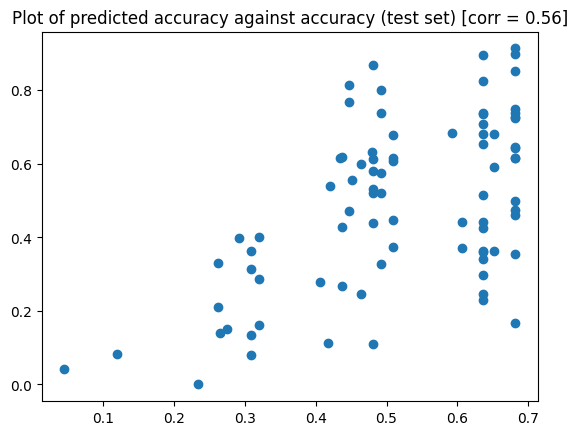

In [50]:
vals = (lr3.predict(W_test))
accuracies = y_test

fig, ax = plt.subplots()

ax.set_title(f"Plot of predicted accuracy against accuracy (test set) [corr = {np.corrcoef(vals, accuracies)[0,1]:.2f}]")
ax.scatter(vals, accuracies)

In [51]:
FEATURE_NAMES = ["Face", "Eyebrows", "Nose", "Eyes", "Mouth", "Hair"]

for v, name in zip(lr3.coef_, FEATURE_NAMES):
    print(f"{name}: {v}")

Face: 0.03000607676360174
Eyebrows: 0.044911822954367187
Nose: 0.04475524829825072
Eyes: 0.17250709256547728
Mouth: 0.18923352148193823
Hair: 0.20026082112939483


In [52]:
def calc(votesamp):
    votes_for = votesamp.groupby("chosen_index").apply(len)
    votes_against = votesamp.groupby("other_index").apply(len)

    vote_prop = np.array([calc_average_votes(votes_for.get(x, default=0), votes_against.get(x, default=0)) for x in range(NUM_SKETCHES)])
    use_images = ~pd.isna(vote_prop)
    
    lr = Ridge(fit_intercept=False)
    lr.fit(face_feature_matrix[use_images], vote_prop[use_images])
    return lr.coef_

calcs = [calc(votes.iloc[inds]) for inds in [np.random.choice(np.arange(len(votes)), size=len(votes)) for _ in range(1000)]]

for vals, name in zip(np.column_stack(calcs), FEATURE_NAMES):
    quantiles = np.quantile(vals, [0.05, 0.25, 0.75, 0.95])
    print(f"{name}: {quantiles}")

Face: [0.02991456 0.03615582 0.04588895 0.05357955]
Eyebrows: [0.04759713 0.05413655 0.06274941 0.06885747]
Nose: [0.02646736 0.03354772 0.04223718 0.04793898]
Eyes: [0.15867652 0.16590244 0.1761408  0.18255401]
Mouth: [0.15743685 0.16384494 0.17296242 0.17921663]
Hair: [0.18399885 0.18980621 0.1985621  0.20549614]


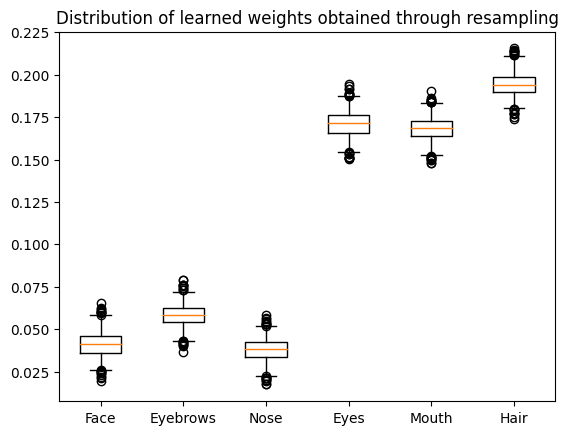

In [53]:
fig, ax = plt.subplots()
ax.set_title("Distribution of learned weights obtained through resampling")
_ = ax.boxplot(np.stack(calcs), labels=FEATURE_NAMES, whis=[1, 99])

P(Eyes | Mouth) = 0.8038461538461539
P(Eyes) = 0.7976190476190477

P(Mouth | Eyes) = 0.7798507462686567
P(Mouth) = 0.7738095238095238


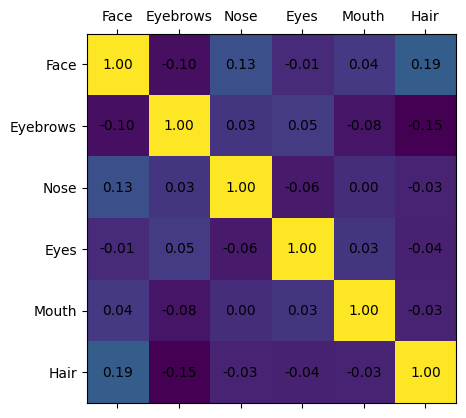

In [25]:
with_eyes = face_feature_matrix[:,3] == 1
with_mouth = face_feature_matrix[:,4] == 1

print("P(Eyes | Mouth) =",(with_eyes & with_mouth).sum() / with_mouth.sum())
print("P(Eyes) =",with_eyes.sum() / len(face_feature_matrix))
print()
print("P(Mouth | Eyes) =",(with_eyes & with_mouth).sum() / with_eyes.sum())
print("P(Mouth) =",with_mouth.sum() / len(face_feature_matrix))

corr = np.corrcoef(face_feature_matrix.T)
fig, ax = plt.subplots()
ax.matshow(corr)
ax.set_xticks(np.arange(6), FEATURE_NAMES)
ax.set_yticks(np.arange(6), FEATURE_NAMES)
for (i, j), v in np.ndenumerate(corr):
    ax.text(j, i, f"{v:.2f}", ha='center', va='center')

Face: 259
Eyebrows: 262
Nose: 222
Eyes: 268
Mouth: 260
Hair: 229


<BarContainer object of 6 artists>

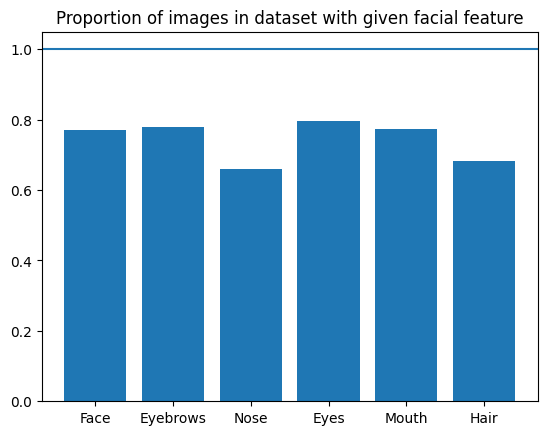

In [96]:
for f, name in zip(face_feature_matrix.sum(axis=0), FEATURE_NAMES):
    print(f"{name}: {f}")

plt.title("Proportion of images in dataset with given facial feature")
plt.axhline(1, 0, 6, color=None, linestyle='solid', label='')
plt.bar(FEATURE_NAMES, face_feature_matrix.mean(axis=0))

(array([  2.,  14.,  40., 102., 126.,  52.]),
 array([1.        , 1.83333333, 2.66666667, 3.5       , 4.33333333,
        5.16666667, 6.        ]),
 <BarContainer object of 6 artists>)

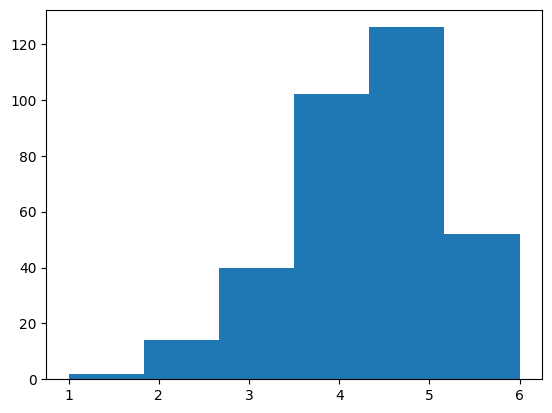

In [27]:
num_features = face_feature_matrix.sum(axis=1)
plt.hist(num_features, bins=6)

(array([2786., 4995., 2381.,  737.,  103.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

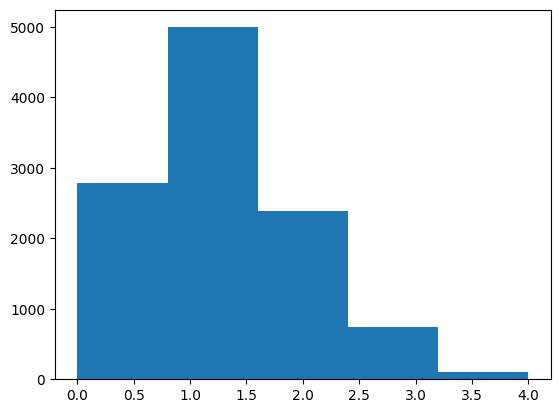

In [28]:
res = np.abs(num_features[chosen_index] - num_features[other_index])
plt.hist(res, bins=5)

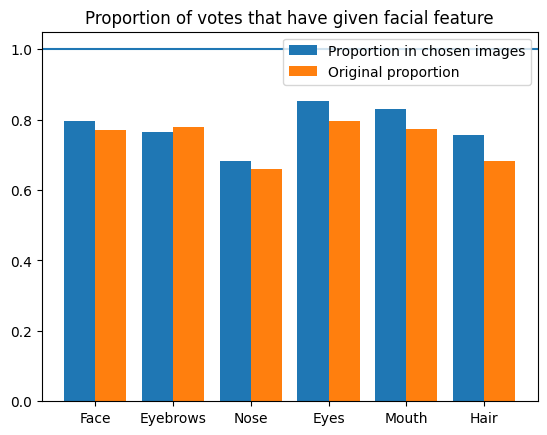

In [104]:
offset = 0.4
plt.title("Proportion of votes that have given facial feature")
plt.axhline(1, 0, 6, color=None, linestyle='solid', label='')
plt.bar(np.arange(6) - offset / 2, face_feature_matrix[votes["chosen_index"]].mean(axis=0), width=offset, label="Proportion in chosen images")
plt.bar(np.arange(6) + offset / 2, face_feature_matrix.mean(axis=0), width=offset, label="Original proportion")
plt.xticks(np.arange(6), FEATURE_NAMES)
plt.legend()

Votes with feature swaps only: 1709


/tmp/ipykernel_18108/2521755900.py:12: RuntimeWarning: invalid value encountered in divide
  pairs /= (pairs + pairs.T)


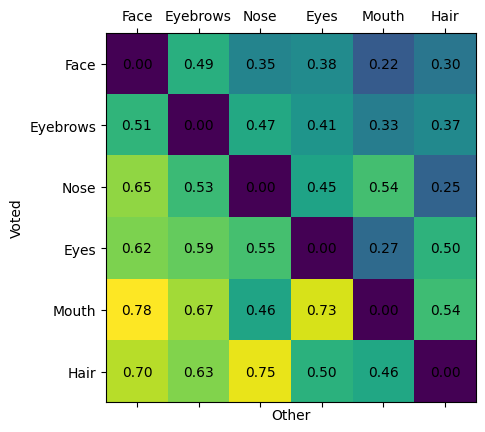

In [88]:
pairs = np.zeros((6, 6))

first_comp = face_feature_matrix[votes["chosen_index"]]
second_comp = face_feature_matrix[votes["other_index"]]
diffs = first_comp - second_comp
hamming_dist = np.abs(diffs).sum(axis=1)
remaining_votes = diffs[(hamming_dist == 2) & (diffs.sum(axis=1) == 0)]

for f,a in zip(remaining_votes.argmax(axis=1), remaining_votes.argmin(axis=1)):
    pairs[f,a] += 1

pairs /= (pairs + pairs.T)
pairs[np.isnan(pairs)] = 0
print(f"Votes with feature swaps only: {len(remaining_votes)}")
fig, ax = plt.subplots()
ax.matshow(pairs)
ax.set_xlabel("Other")
ax.set_ylabel("Voted")
ax.set_xticks(np.arange(6), FEATURE_NAMES)
ax.set_yticks(np.arange(6), FEATURE_NAMES)
for (i, j), v in np.ndenumerate(pairs):
    ax.text(j, i, f"{v:.2f}", ha='center', va='center')

# Scratch space

In [29]:
def f1_score(label):
    actual = true_image == label
    predicted = chosen_image == label
    tp = (actual & predicted).sum()
    fp = (~actual & predicted).sum()
    fn = (actual & ~predicted).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return (precision, recall, 2*precision*recall/(precision+recall))